In [ ]:
with open("/content/drive/MyDrive/scraping/output.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

# リスト内包表記を使用して各行から改行文字を削除し、さらに数字とピリオドを削除します
lines = [line.strip().split('. ')[-1] for line in lines]

print(lines)


['冷静', '熱烈', '楽観的', '悲観的', '謙虚', '傲慢', '礼儀正しい', '無礼な', '勇敢', '臆病', '知的', '知恵がある', '知らないフリをする', '話し上手', '飽きっぽい', '耐えられる', '信頼できる', '不信感がある', '情熱的', '冷淡', '楽天家', '悲観主義者', '自分に自信がある', '自信不足', '論理的', '感情的', '自分に厳しい', '自分に甘い', '陽気', '気分屋', 'サバサバした', 'めんどくさがり', '毅然とした', '派手好き', '内気', '頑固', '革新的', '保守的', '非現実的', '現実的', '身勝手', '無関心', '手加減がない', '優柔不断', '慎重', '無茶をする', '楽天的', '実用主義', '容易に感銘を受ける', '過去にこだわる', '現在を楽しむ', '積極的', '消極的', '自己中心的', '共感力がある', '社交性がある', '孤独を愛する', '高飛車', '素直', '開放的', '閉鎖的', '巨匠気取り', '控えめ', '偏屈', '自尊心が強い', '謙遜する', '真面目', 'ジョーク好き', '人を惹きつける', 'ナルシスト', '距離を置く', '前向き', '消極的', '責任感がある', '責任回避をする', 'スマート', 'ロマンチスト', 'リアリスト', '繊細', 'ハンサム', '無愛想', '思いやりがある', 'かたい人', 'はっきりという', '仕事熱心', '欲張り', '人好き', '性悪', '辛抱強い', '陰気', '浮気者', 'ムードメーカー', '嫉妬深い', '裏表がある', '社交的', '関心が広い', '短気', '怒りっぽい', '物事を深く考える', '表現が得意', '荒削り', 'マイペース', '心配性', '世話好き', '自由奔放', '幼稚', '成熟した', '真似っこ', 'ポジティブ', 'スタイリッシュ', '個性的', 'チャンスをつかむ', '自己主張が強い', '人当たりが良い', '悩みが多い', 'いつも笑っている', '変わり者', 'しっかり者', '常識人', '正直', '冷たい', '手

In [ ]:
len(lines)

300

In [ ]:
obj = {}

for i in lines:
  emb = openai.Embedding.create(input = i, model="text-embedding-ada-002")['data'][0]['embedding']
  obj[i] = emb

In [ ]:
import json

word_vectors = obj

# テキストファイルに辞書を出力
with open('word_vectors.txt', 'w', encoding='utf-8') as f:
    json.dump(word_vectors, f, ensure_ascii=False)


In [ ]:
from collections import defaultdict
def get_duplicates_with_indices(lst):
    elem_indices = defaultdict(list)
    for index, elem in enumerate(lst):
        elem_indices[elem].append(index)

    return {elem: indices for elem, indices in elem_indices.items() if len(indices) > 1}

duplicates = get_duplicates_with_indices(lines)

for duplicate, indices in duplicates.items():
    print(f"重複した要素: '{duplicate}', インデックス: {indices}")

In [ ]:
# 合成したいファイルのリスト
files = ['/content/drive/MyDrive/scraping/example_1.txt', '/content/drive/MyDrive/scraping/example _3.txt', '/content/drive/MyDrive/scraping/example _2.txt']

# 新しいファイルに書き込む
with open('merged.txt', 'w', encoding='utf-8') as outfile:
    for fname in files:
        with open(fname, 'r', encoding='utf-8') as infile:
            outfile.write(infile.read())
            outfile.write("\n")  # 各ファイルの内容を改行で分ける


In [ ]:
!pip install openai
import openai
openai.api_key = "XXXXXXXXXXXXXXXXXXXXX"

In [ ]:
#@title 事前学習ベクトルを取得
import json

# テキストファイルから辞書を読み込む
with open('/content/drive/MyDrive/scraping/character_encoder/word_vectors.txt', 'r', encoding='utf-8') as f:
    word_vectors = json.load(f)

In [ ]:
#@title モデルクラス定義
import torch
import torch.nn as nn
from torch.nn import CosineSimilarity
import torch.nn.functional as F
from torch.utils.data import Dataset

class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, output_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        output = self.fc3(h)
        output_norm = output / output.norm(p=2, dim=1, keepdim=True)  # Normalize the output vector
        return output_norm


class WordPairDataset(Dataset):
    def __init__(self, filepath, word_vectors):
        self.filepath = filepath
        self.word_vectors = word_vectors
        self.samples = self.load_samples()

    def load_samples(self):
        samples = []
        with open(self.filepath, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) != 3:
                    continue  # Ignore lines that do not have exactly three parts
                word1, word2, score_str = parts
                if word1 not in self.word_vectors or word2 not in self.word_vectors:
                    continue  # Ignore words that are not in the word vectors
                try:
                    score = float(score_str)
                except ValueError:
                    continue  # Ignore scores that cannot be converted to a float
                samples.append((self.word_vectors[word1], self.word_vectors[word2], score))
        return samples

    def __getitem__(self, index):
        word_vector1, word_vector2, score = self.samples[index]

        # Convert word vectors from list to tensor
        word_tensor1 = torch.tensor(word_vector1, dtype=torch.float32)
        word_tensor2 = torch.tensor(word_vector2, dtype=torch.float32)

        # Convert score to float tensor
        score = torch.tensor(score, dtype=torch.float32)

        return word_tensor1, word_tensor2, score

    def __len__(self):
        return len(self.samples)

In [ ]:
#@title 学習ステップ
from torch.utils.data import random_split
from torch.utils.data import DataLoader

#hyper parameter
num_epochs = 1000
emb_size = 300
batch_size= 2048
learning_rate = 0.01

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialization
model = Encoder(1536, emb_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
cos_sim = CosineSimilarity(dim=1)

# Load the full dataset
full_dataset = WordPairDataset('/content/drive/MyDrive/scraping/character_encoder/dataset.txt', word_vectors)

# Split the dataset into training, validation, and test datasets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_loss_list = []
loss_list = []

# Train the model
for epoch in range(num_epochs):
    for word1, word2, target in train_loader:
        word1 = word1.to(device)
        word2 = word2.to(device)
        target = target.to(device)

        # Forward pass
        output1, output2 = model(word1), model(word2)
        cosine_similarity = F.cosine_similarity(output1, output2)
        loss = criterion(cosine_similarity, target)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on the validation dataset
    with torch.no_grad():
        val_loss = 0
        for word1, word2, target in val_loader:
            word1 = word1.to(device)
            word2 = word2.to(device)
            target = target.to(device)

            # Forward pass
            output1, output2 = model(word1), model(word2)
            cosine_similarity = F.cosine_similarity(output1, output2)
            val_loss += criterion(cosine_similarity, target).item()

        val_loss /= len(val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Val Loss: {val_loss}')
        val_loss_list.append(val_loss)
        loss_list.append(loss.item())

# Test the model
with torch.no_grad():
    test_loss = 0
    for word1, word2, target in test_loader:
        word1 = word1.to(device)
        word2 = word2.to(device)
        target = target.to(device)

        # Forward pass
        output1, output2 = model(word1), model(word2)
        cosine_similarity = F.cosine_similarity(output1, output2)
        test_loss += criterion(cosine_similarity, target).item()

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss}')


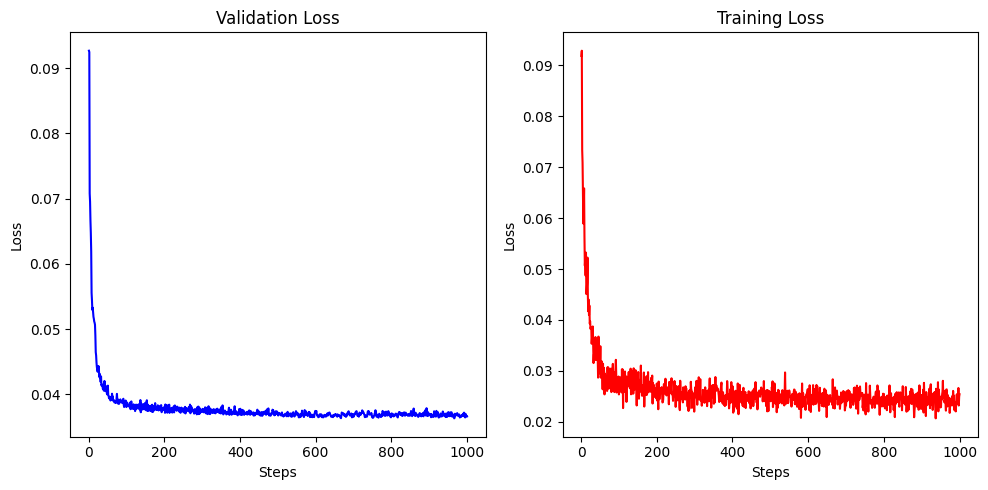

In [ ]:
#@title 損失をトレース
import matplotlib.pyplot as plt

# データ
steps = list(range(1, 1001))  # ステップリスト（1から1000まで）
#val_loss_list = # ここに検証用損失リストを入力
#loss_list = # ここに訓練用損失リストを入力

# 描画領域を作成
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1行2列の横並びグラフ

# 検証用損失のグラフ
ax1.plot(steps, val_loss_list, color='blue')
ax1.set_title('Validation Loss')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')

# 訓練用損失のグラフ
ax2.plot(steps, loss_list, color='red')
ax2.set_title('Training Loss')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Loss')

# グラフを表示
plt.tight_layout()  # グラフ間のスペースを自動調整
plt.show()


In [ ]:
#@title 学習したモデルを保存
import json
model_path = '/content/drive/MyDrive/scraping/character_encoder/model1000.pth'
config_path = '/content/drive/MyDrive/scraping/character_encoder/model1000.json'

e_config = {"num_epochs":num_epochs,"emb_size":emb_size,"batch_size":batch_size,"learning_rate":learning_rate,"model_path":model_path}

torch.save(model.state_dict(), model_path)

# JSON形式でファイルに書き出す
with open(config_path, 'w') as f:
    json.dump(e_config, f)

In [ ]:
#@title モデルを再ロード
model = Encoder(1536, 300)
model.load_state_dict(torch.load('/content/drive/MyDrive/scraping/character_encoder/model1000.pth'))
#model.eval()  # Important: set the model to evaluation mode


<All keys matched successfully>

In [ ]:
#@title 精度評価
def evaluate_accuracy(model, data_loader):
    model.eval()  # set the model to evaluation mode
    total_samples = 0
    total_correct = 0
    with torch.no_grad():
        for word1, word2, target in data_loader:
            word1, word2, target = word1.to(device), word2.to(device), target.to(device)
            output1 = model(word1)
            output2 = model(word2)
            # Compute the cosine similarity between the two output vectors
            outputs = F.cosine_similarity(output1, output2)
            # Here we check if the absolute difference between target and outputs is less than 0.05
            correct = torch.abs(target - outputs).lt(0.2)
            total_correct += correct.sum().item()
            total_samples += correct.size(0)
    accuracy = total_correct / total_samples
    return accuracy

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

#hyper parameter
num_epochs = 100
emb_size = 300
batch_size= 1024
learning_rate = 0.01

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialization
model = Encoder(1536, emb_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
cos_sim = CosineSimilarity(dim=1)

# Load the full dataset
full_dataset = WordPairDataset('/content/drive/MyDrive/scraping/character_encoder/dataset.txt', word_vectors)

# Split the dataset into training, validation, and test datasets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# After training, load the best model
#model.load_state_dict(torch.load('/content/drive/MyDrive/scraping/character_encoder/model1000.pth'))

test_accuracy = evaluate_accuracy(model, test_loader)
print(f'Test Accuracy: {test_accuracy}')


Test Accuracy: 0.8497354497354498


In [ ]:
#@title 検証用
with open("/content/性格.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

text_list = []
vec_list = []
new_vec_list = []

for t in lines:
  emb = openai.Embedding.create(input = t.strip(), model="text-embedding-ada-002")['data'][0]['embedding']
  vec_list.append(emb)
  text_list.append(t.strip())

In [ ]:
model.eval()

with torch.no_grad():
  for v in vec_list:
    x = torch.tensor(v).to(device)
    x = x.view(1,-1)
    output = model(x)
    new_vec_list.append(output.view(-1).tolist())

In [ ]:
!pip install japanize-matplotlib

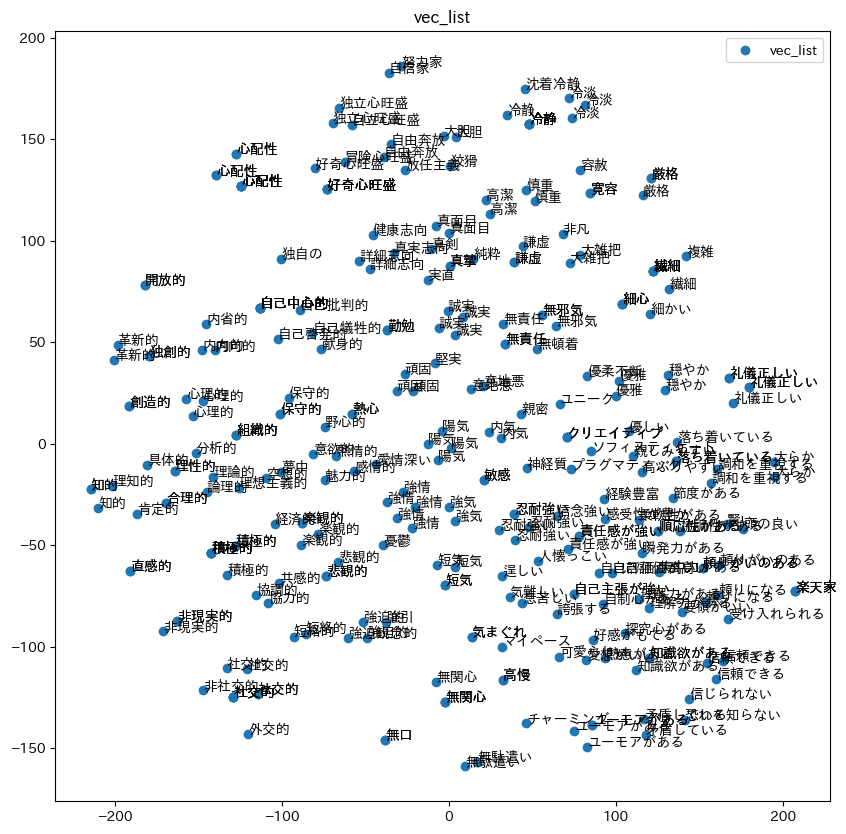

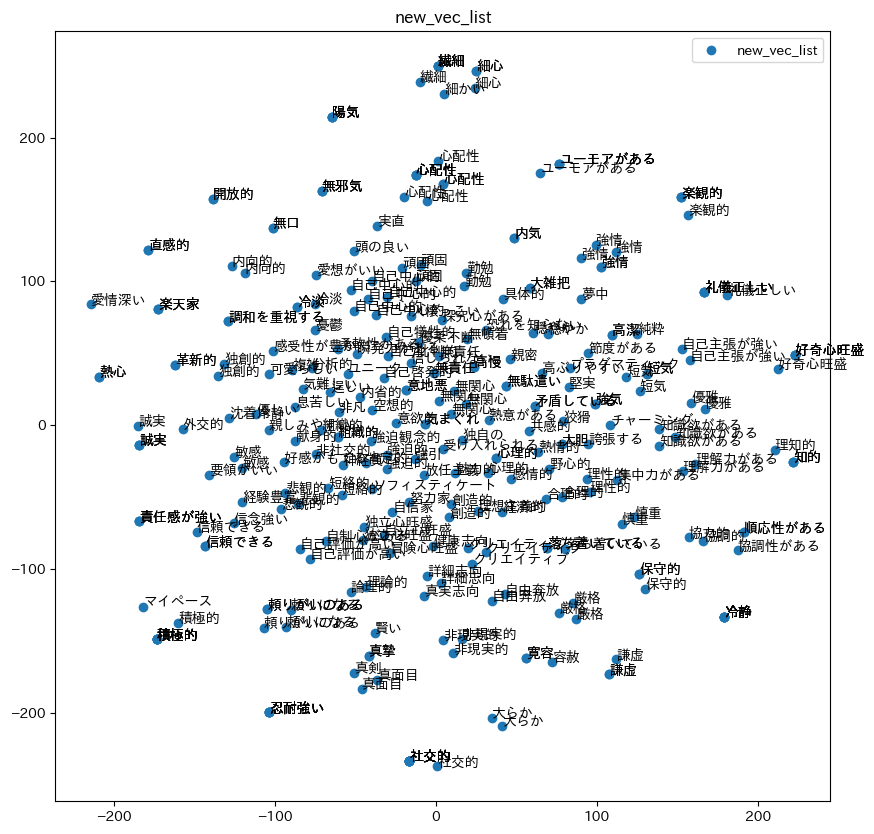

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import japanize_matplotlib
import numpy as np

# リストをNumPyのndarrayに変換します。
vec_array = np.array(vec_list)
new_vec_array = np.array(new_vec_list)

# t-SNEで2次元に削減します。
tsne = TSNE(n_components=2)
vec_list_2d = tsne.fit_transform(vec_array)
new_vec_list_2d = tsne.fit_transform(new_vec_array)

# データを分解します。
vec_x, vec_y = zip(*vec_list_2d)
new_vec_x, new_vec_y = zip(*new_vec_list_2d)

# vec_listのグラフを作成します。
plt.figure(figsize=(10, 10))
plt.scatter(vec_x, vec_y, label='vec_list')
for i, text in enumerate(text_list):
    plt.text(vec_x[i], vec_y[i], text)
plt.legend()
plt.title('vec_list')
plt.show()

# new_vec_listのグラフを作成します。
plt.figure(figsize=(10, 10))
plt.scatter(new_vec_x, new_vec_y, label='new_vec_list')
for i, text in enumerate(text_list):
    plt.text(new_vec_x[i], new_vec_y[i], text)
plt.legend()
plt.title('new_vec_list')
plt.show()



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_similarity(v, vec_list):
    """
    ベクトルvとvec_list内の各ベクトルとのコサイン類似度を計算する関数。
    """
    # ndarray形式に変換します。
    v = np.array(v)
    vec_array = np.array(vec_list)

    # vが1Dの場合、2Dにリシェイプします。
    if len(v.shape) == 1:
        v = v.reshape(1, -1)

    # コサイン類似度を計算します。
    similarity_scores = cosine_similarity(v, vec_array)

    return similarity_scores[0]  # 2D配列を1Dにフラット化します。

def get_top_k_indices(similarity_scores, k):
    """
    類似度スコアの高いトップkのインデックスを取得します。
    """
    # スコアを降順にソートし、そのインデックスを取得します。
    sorted_indices = np.argsort(similarity_scores)[::-1]

    # トップkのインデックスを返します。
    return sorted_indices[:k]


# あなたのベクトルvとvec_listを定義します。
input = "温和で献身的"
v = openai.Embedding.create(input = input, model="text-embedding-ada-002")['data'][0]['embedding']

model.eval()
with torch.no_grad():
    x = torch.tensor(v).to(device)
    x = x.view(1,-1)
    output = model(x)
    v = output.view(-1).tolist()

# コサイン類似度を計算します。
similarity_scores = calculate_similarity(v, new_vec_list)

# トップkのアイテムとそのスコアを取得します。ここでは、k=3とします。
k = 30
top_k_indices = get_top_k_indices(similarity_scores, k)

# 結果を表示します。
print(f"target: {input}")
for index in top_k_indices:
    print(f'Text: {text_list[index]}, Score: {similarity_scores[index]}')


target: 温和で献身的
Text: 穏やか, Score: 0.9555195623334487
Text: 穏やか, Score: 0.9554909543909621
Text: 探究心がある, Score: 0.9251546217553098
Text: 放任主義, Score: 0.9250116356569869
Text: プラグマティック, Score: 0.9244393810076933
Text: 熱意がある, Score: 0.9199626904205009
Text: 無関心, Score: 0.9176176593717128
Text: 無関心, Score: 0.9176176593717128
Text: 無関心, Score: 0.9176176593717128
Text: 無関心, Score: 0.9176176593717128
Text: 保守的, Score: 0.9106557387279308
Text: 保守的, Score: 0.9106557387279308
Text: 保守的, Score: 0.9106557387279308
Text: 気まぐれ, Score: 0.9105108170516789
Text: 気まぐれ, Score: 0.9105108170516789
Text: 意欲的, Score: 0.9074510986174409
Text: 内気, Score: 0.8992535404928679
Text: 内気, Score: 0.8992535404928679
Text: 強引, Score: 0.8928889899067001
Text: 無責任, Score: 0.8924078430024497
Text: 無責任, Score: 0.8924078430024497
Text: 無責任, Score: 0.8924078430024497
Text: 寛容, Score: 0.891662218316585
Text: 寛容, Score: 0.891662218316585
Text: 親密, Score: 0.8912245899493079
Text: 献身的, Score: 0.8891820547575913
Text: 高慢, Score: 0

In [ ]:
def get_bottom_k_indices(similarity_scores, k):
    """
    類似度スコアの低いbottom kのインデックスを取得します。
    """
    # スコアを昇順にソートし、そのインデックスを取得します。
    sorted_indices = np.argsort(similarity_scores)

    # bottom kのインデックスを返します。
    return sorted_indices[:k]

# bottom kのアイテムとそのスコアを取得します。ここでは、k=3とします。
k = 30
bottom_k_indices = get_bottom_k_indices(similarity_scores, k)

# 結果を表示します。
print(f"target: {text_list[0]}")
for index in bottom_k_indices:
    print(f'Text: {text_list[index]}, Score: {similarity_scores[index]}')


target: 積極的
Text: 真面目, Score: 0.4714001075710157
Text: 真面目, Score: 0.4714250304560312
Text: 真剣, Score: 0.4929724310250797
Text: 真実志向, Score: 0.4974358168821209
Text: 繊細, Score: 0.5510734603551198
Text: 繊細, Score: 0.5510734603551198
Text: 繊細, Score: 0.5510734603551198
Text: 繊細, Score: 0.5510734603551198
Text: 繊細, Score: 0.5513497401202618
Text: 大らか, Score: 0.5575365853668142
Text: 大らか, Score: 0.5576574021472696
Text: 真摯, Score: 0.5636596161838205
Text: 真摯, Score: 0.5636596161838205
Text: 好奇心旺盛, Score: 0.5681928333336812
Text: 好奇心旺盛, Score: 0.56826746120522
Text: 好奇心旺盛, Score: 0.56826746120522
Text: 好奇心旺盛, Score: 0.56826746120522
Text: 好奇心旺盛, Score: 0.56826746120522
Text: 熱心, Score: 0.5715274959322219
Text: 熱心, Score: 0.5715274959322219
Text: 楽観的, Score: 0.5722315490579906
Text: 楽観的, Score: 0.5723511863220578
Text: 楽観的, Score: 0.5723511863220578
Text: 楽観的, Score: 0.5723511863220578
Text: 細心, Score: 0.5807190879951618
Text: 細心, Score: 0.5807190879951618
Text: 細心, Score: 0.5807190879951618